In [18]:
import os
from dotenv import dotenv_values

In [19]:
config = dotenv_values("./keys/.env")

In [20]:
from dotenv import dotenv_values
import json
import vertexai
from google.oauth2 import service_account
from vertexai.generative_models import GenerationConfig, GenerativeModel, Image, Part

In [21]:

with open("./keys/complete-tube-421007-208a4862c992.json") as source:
    info = json.load(source)

vertex_credentials = service_account.Credentials.from_service_account_info(info)
vertexai.init(
    project=config["PROJECT"],
    location=config["REGION"],
    credentials=vertex_credentials,
)
google_api_key = config["GEMINI-API-KEY"]
os.environ["GEMINI_API_KEY"] = google_api_key

In [5]:
model = GenerativeModel("gemini-1.5-pro")

In [6]:
import http.client
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def get_url_from_gcs(gcs_uri: str) -> str:
    # converts GCS uri to url for image display.
    url = "https://storage.googleapis.com/" + gcs_uri.replace("gs://", "").replace(
        " ", "%20"
    )
    return url


def print_multimodal_prompt(contents: list):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if isinstance(content, Image):
            display_images([content])
        elif isinstance(content, Part):
            url = get_url_from_gcs(content.file_data.file_uri)
            IPython.display.display(load_image_from_url(url))
        else:
            print(content)

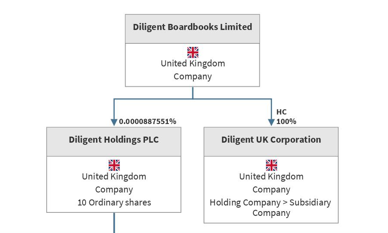

In [22]:
# Load from local file
example_image = Image.load_from_file("data/example.png")
example_image

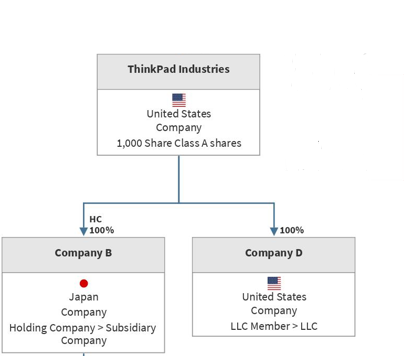

In [23]:
# Load from local file
example_image2 = Image.load_from_file("data/example2.png")
example_image2

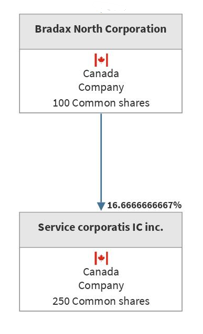

In [24]:
image =  Image.load_from_file("data/question.png")
image

In [25]:
# Prepare prompts
prompt1 = """{"Company Name": "Diligent Boardbooks Limited", "owns": [ {"name" :"Diligent Holdings PLC", "percentage": "0.0000887551%"},
{"name" :"Diligent UK Corporation", "percentage": "100%"}]}"""
# Prepare prompts
prompt2 = """{"Company Name": "ThinkPad Insdustries", "owns": [ {"name" :"Company B, "percentage": "100%"},
{"name" :"Company D", "percentage": "100%"}]}"""

In [26]:
generation_config = GenerationConfig(
    temperature=0.1,
    top_p=1.0,
    top_k=32,
    candidate_count=1,
    max_output_tokens=8192,
)

In [27]:
#question = "From this Image localize the Subsidiarie ThinkPad Insdustries. Describe it like in the example"

In [28]:
# Prepare contents
contents = [example_image, prompt1,example_image2, prompt2, image]

In [29]:
responses = model.generate_content(contents)

In [30]:
print("\n-------Response--------")
print(responses.text)


-------Response--------
{"Company Name": "Bradax North Corporation", "owns": [ {"name" :"Service corporatis IC inc.", "percentage": "16.666666666666667%"}]}


In [31]:
r = {"Company Name": "Bradax North Corporation", "owns": [{"name" :"Service corporatis IC inc.", "percentage": "16.66666666666667%"}]}

In [32]:
r

{'Company Name': 'Bradax North Corporation',
 'owns': [{'name': 'Service corporatis IC inc.',
   'percentage': '16.66666666666667%'}]}